In [41]:
import torch.nn as nn
import torch 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

# NN Classification (Perceptron) : gender

## Data preparation

### Load data: NOUN, ADJ, and both

In [25]:
df_nouns_we = pd.read_csv('../Data/FlauBERT_WE/all_nouns_we.csv').drop(columns=["number"])
df_adj_we = pd.read_csv('../Data/FlauBERT_WE/all_adjectives_we.csv').drop(columns = "number")
df_both_we = pd.concat([df_nouns_we, df_adj_we], ignore_index=True)

# target : gender
Y_gd_N = df_nouns_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)
Y_gd_A = df_adj_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)
Y_gd_both = df_both_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)

# features : word embeddings dimensions
X_gd_N = df_nouns_we.drop(columns=["Word", "gender"])
X_gd_A = df_adj_we.drop(columns=["Word", "gender"])
X_gd_both = df_both_we.drop(columns = ["Word", "gender"] )

# normalize data to be between 0 and 1
X_gd_N = (X_gd_N - X_gd_N.min()) / (X_gd_N.max() - X_gd_N.min())
X_gd_A = (X_gd_A - X_gd_A.min()) / (X_gd_A.max() - X_gd_A.min())
X_gd_both = (X_gd_both - X_gd_both.min()) / (X_gd_both.max() - X_gd_both.min())

# split data into train and test sets
X_gd_N_train, X_gd_N_test, Y_gd_N_train, Y_gd_N_test = train_test_split(X_gd_N, Y_gd_N, test_size=0.2, random_state=42)
X_gd_A_train, X_gd_A_test, Y_gd_A_train, Y_gd_A_test = train_test_split(X_gd_A, Y_gd_A, test_size=0.2, random_state=42)
X_gd_both_train, X_gd_both_test, Y_gd_both_train, Y_gd_both_test = train_test_split(X_gd_both, Y_gd_both, test_size=0.2, random_state=42)

In [26]:
# print all the shapes
print("X_gd_N_train shape : ", X_gd_N_train.shape)
print("X_gd_N_test shape : ", X_gd_N_test.shape)
print("Y_gd_N_train shape : ", Y_gd_N_train.shape)
print("Y_gd_N_test shape : ", Y_gd_N_test.shape)
print("X_gd_A_train shape : ", X_gd_A_train.shape)
print("X_gd_A_test shape : ", X_gd_A_test.shape)
print("Y_gd_A_train shape : ", Y_gd_A_train.shape)
print("Y_gd_A_test shape : ", Y_gd_A_test.shape)
print("X_gd_both_train shape : ", X_gd_both_train.shape)
print("X_gd_both_test shape : ", X_gd_both_test.shape)

X_gd_N_train shape :  (10590, 512)
X_gd_N_test shape :  (2648, 512)
Y_gd_N_train shape :  (10590,)
Y_gd_N_test shape :  (2648,)
X_gd_A_train shape :  (5067, 512)
X_gd_A_test shape :  (1267, 512)
Y_gd_A_train shape :  (5067,)
Y_gd_A_test shape :  (1267,)
X_gd_both_train shape :  (15657, 512)
X_gd_both_test shape :  (3915, 512)


In [27]:
train_features = [X_gd_N_train, X_gd_A_train, X_gd_both_train]
test_features = [X_gd_N_test, X_gd_A_test, X_gd_both_test]
train_targets = [Y_gd_N_train, Y_gd_A_train, Y_gd_both_train]
test_targets = [Y_gd_N_test, Y_gd_A_test, Y_gd_both_test]

### Tensors

In [28]:
# convert to tensors
train_features = [torch.tensor(x.values).float() for x in train_features]
test_features = [torch.tensor(x.values).float() for x in test_features]
train_targets = [torch.tensor(x.values).long() for x in train_targets]
test_targets = [torch.tensor(x.values).long() for x in test_targets]

In [29]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_sets = [TensorDataset(X_train, Y_train) for X_train, Y_train in zip(train_features, train_targets)]
test_sets = [TensorDataset(X_valid, Y_valid) for X_valid, Y_valid in zip(test_features, test_targets)]

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers
train_loaders = [DataLoader(train_set, batch_size=32, shuffle=True) for train_set in train_sets]
test_loaders = [DataLoader(test_set, batch_size=32) for test_set in test_sets]

## Classification

### NN definition

In [30]:
NNlist = []

for i in range(3):
    
    # create a fully connected perceptron with 1 input layer (512 features) and 1 output layer (2 classes)
    model = nn.Sequential(nn.Linear(512, 2), nn.Softmax(dim=1))
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # add the model to the list
    NNlist.append([model, loss_fn, optimizer])

## Train the models

In [34]:
nb_epochs = 100

In [35]:
# train the models 
for i in range(3):
    print("* Training model ", i)
    model, loss_fn, optimizer = NNlist[i]
    # put the model in training mode
    model.train()
    for epoch in range(nb_epochs):
        for X_train, Y_train in train_loaders[i]:
            # compute the model output
            Y_pred = model(X_train)
            # calculate loss
            loss = loss_fn(Y_pred, Y_train)
            # reset the gradients
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # update model weights
            optimizer.step()

        if epoch % 10 == 0:
            print("--Epoch ", epoch, " Loss : ", loss.item())

* Training model  0
--Epoch  0  Loss :  0.44928836822509766
--Epoch  10  Loss :  0.40778687596321106
--Epoch  20  Loss :  0.4188758134841919
--Epoch  30  Loss :  0.35702964663505554
--Epoch  40  Loss :  0.3994632661342621
--Epoch  50  Loss :  0.3960329592227936
--Epoch  60  Loss :  0.427769273519516
--Epoch  70  Loss :  0.42031335830688477
--Epoch  80  Loss :  0.36238235235214233
--Epoch  90  Loss :  0.4037401080131531
* Training model  1
--Epoch  0  Loss :  0.3855551779270172
--Epoch  10  Loss :  0.33439791202545166
--Epoch  20  Loss :  0.34737130999565125
--Epoch  30  Loss :  0.33789655566215515
--Epoch  40  Loss :  0.3277669847011566
--Epoch  50  Loss :  0.3215938210487366
--Epoch  60  Loss :  0.31783828139305115
--Epoch  70  Loss :  0.31669989228248596
--Epoch  80  Loss :  0.3244626224040985
--Epoch  90  Loss :  0.318724125623703
* Training model  2
--Epoch  0  Loss :  0.3971638083457947
--Epoch  10  Loss :  0.43574216961860657
--Epoch  20  Loss :  0.39378783106803894
--Epoch  30  

Model  0 
 Accuracy :  0.952416918429003
 Precision :  0.953125
 Recall :  0.9572039842605591
 F1 score :  0.9551601409912109
Confusion matrix : 


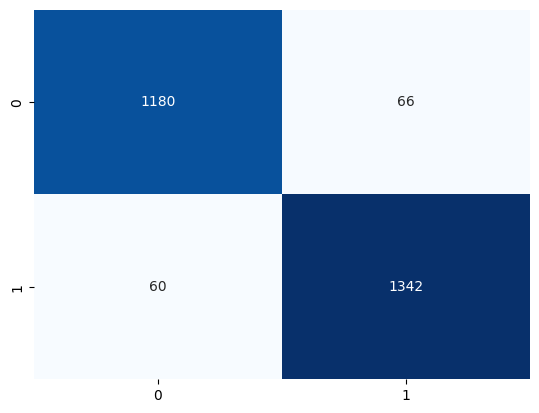

Model  1 
 Accuracy :  0.9921073401736386
 Precision :  0.9912280440330505
 Recall :  0.996221661567688
 F1 score :  0.9937186241149902
Confusion matrix : 


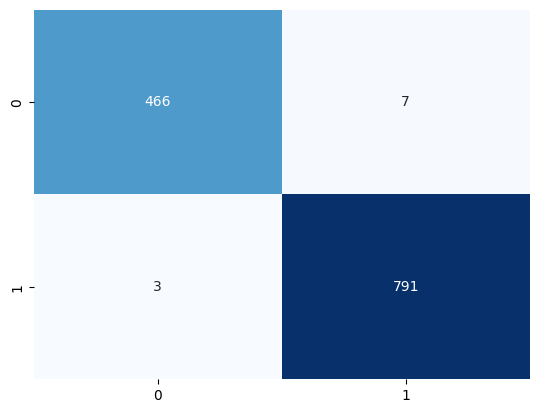

Model  2 
 Accuracy :  0.9578544061302682
 Precision :  0.9583333134651184
 Recall :  0.9674355387687683
 F1 score :  0.9628629088401794
Confusion matrix : 


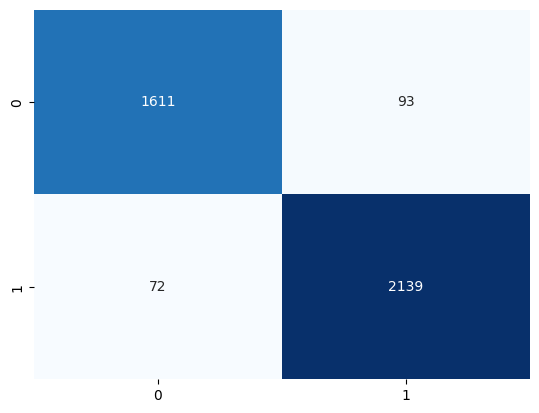

In [46]:
# display the confusion matrix
for i in range(3):

    # put the model in evaluation mode
    NNlist[i][0].eval()
    # initialize the number of correct predictions
    nb_correct_pred = 0
    # initialize the number of predictions
    nb_pred = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(2, 2)
    # iterate over batches
    for X_test, Y_test in test_loaders[i]:
        # compute the model output
        with torch.no_grad():
            Y_pred = NNlist[i][0](X_test)
            # get the predicted class
            Y_pred = torch.argmax(Y_pred, dim=1)
            # compute the number of correct predictions
            nb_correct_pred += (Y_pred == Y_test).sum().item()
            # compute the number of predictions
            nb_pred += Y_pred.shape[0]
            # update the confusion matrix
            for t, p in zip(Y_test.view(-1), Y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # compute the accuracy
    accuracy = nb_correct_pred / nb_pred
    # compute the precision, recall and f1 score
    precision = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
    recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    f1_score = 2 * precision * recall / (precision + recall)
    # print the results
    print("Model ", i, "\n Accuracy : ", accuracy)
    print(" Precision : ", float(precision))
    print(" Recall : ", float(recall))
    print(" F1 score : ", float(f1_score))
    print("Confusion matrix : ")
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.show()

In [60]:
# get the weights of the first layer of the model trained on the three datasets
weights = [NNlist[i][0][0].weight.data.numpy() for i in range(3)]

In [61]:
print(weights[0].shape)
print(weights[0])

(2, 512)
[[ 0.946667    0.3289947  -0.312579   ...  0.5172174   0.6399834
  -0.06748576]
 [-0.977395   -0.31467578  0.2601018  ... -0.49514124 -0.6485724
   0.10949831]]


In [77]:
# store the weights in a pandas dataframe
weights_df = pd.DataFrame(weights[0], columns=X_gd_N_train.columns)
weights_df['dataset'] = 'N'
weights_df = weights_df.append(pd.DataFrame(weights[1], columns=X_gd_A_train.columns))
weights_df['dataset'] = weights_df['dataset'].fillna('A')
weights_df = weights_df.append(pd.DataFrame(weights[2], columns=X_gd_both_train.columns))
weights_df['dataset'] = weights_df['dataset'].fillna('both')

# set the dataset as index
weights_df = weights_df.set_index('dataset')

C:\Users\bleuze3u\AppData\Local\Temp\ipykernel_7572\2365961212.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df = weights_df.append(pd.DataFrame(weights[1], columns=X_gd_A_train.columns))
C:\Users\bleuze3u\AppData\Local\Temp\ipykernel_7572\2365961212.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df = weights_df.append(pd.DataFrame(weights[2], columns=X_gd_both_train.columns))


In [78]:
weights_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
dataset,,,,,,,,,,,,,,,,,,,,,
N,0.946667,0.328995,-0.312579,-0.090479,0.910950,-1.222433,-0.255966,-1.739187,0.981225,0.445455,...,-0.258886,0.953946,-0.247603,0.603725,0.152848,-1.563966,-0.507532,0.517217,0.639983,-0.067486
N,-0.977395,-0.314676,0.260102,0.113210,-0.866695,1.221905,0.270446,1.793385,-1.020690,-0.371290,...,0.286010,-0.971046,0.216638,-0.659413,-0.172539,1.549972,0.550567,-0.495141,-0.648572,0.109498
A,0.678695,0.226172,-0.539917,-0.184077,0.485116,-1.391242,-0.285240,-0.691932,0.336490,0.423272,...,0.092510,1.069508,0.126817,0.310596,-0.612990,-1.051207,0.056208,0.270424,0.104722,0.578843
A,-0.672854,-0.239842,0.536785,0.194373,-0.560142,1.412885,0.292001,0.719256,-0.328226,-0.449428,...,-0.136758,-1.060259,-0.202468,-0.299049,0.587296,1.056015,-0.096247,-0.250932,-0.134551,-0.506044
both,1.277770,0.243546,-0.871718,0.020121,1.048579,-1.666953,-0.349495,-1.990550,1.178329,0.443674,...,-0.247347,1.326856,-0.206623,1.011938,-0.001154,-1.844594,-0.531743,0.654512,0.639387,-0.116262
both,-1.210747,-0.248900,0.899029,0.034759,-1.069722,1.661734,0.364467,1.962601,-1.187109,-0.398417,...,0.254015,-1.332695,0.174075,-1.033593,0.034915,1.805110,0.521252,-0.663627,-0.650128,0.073868


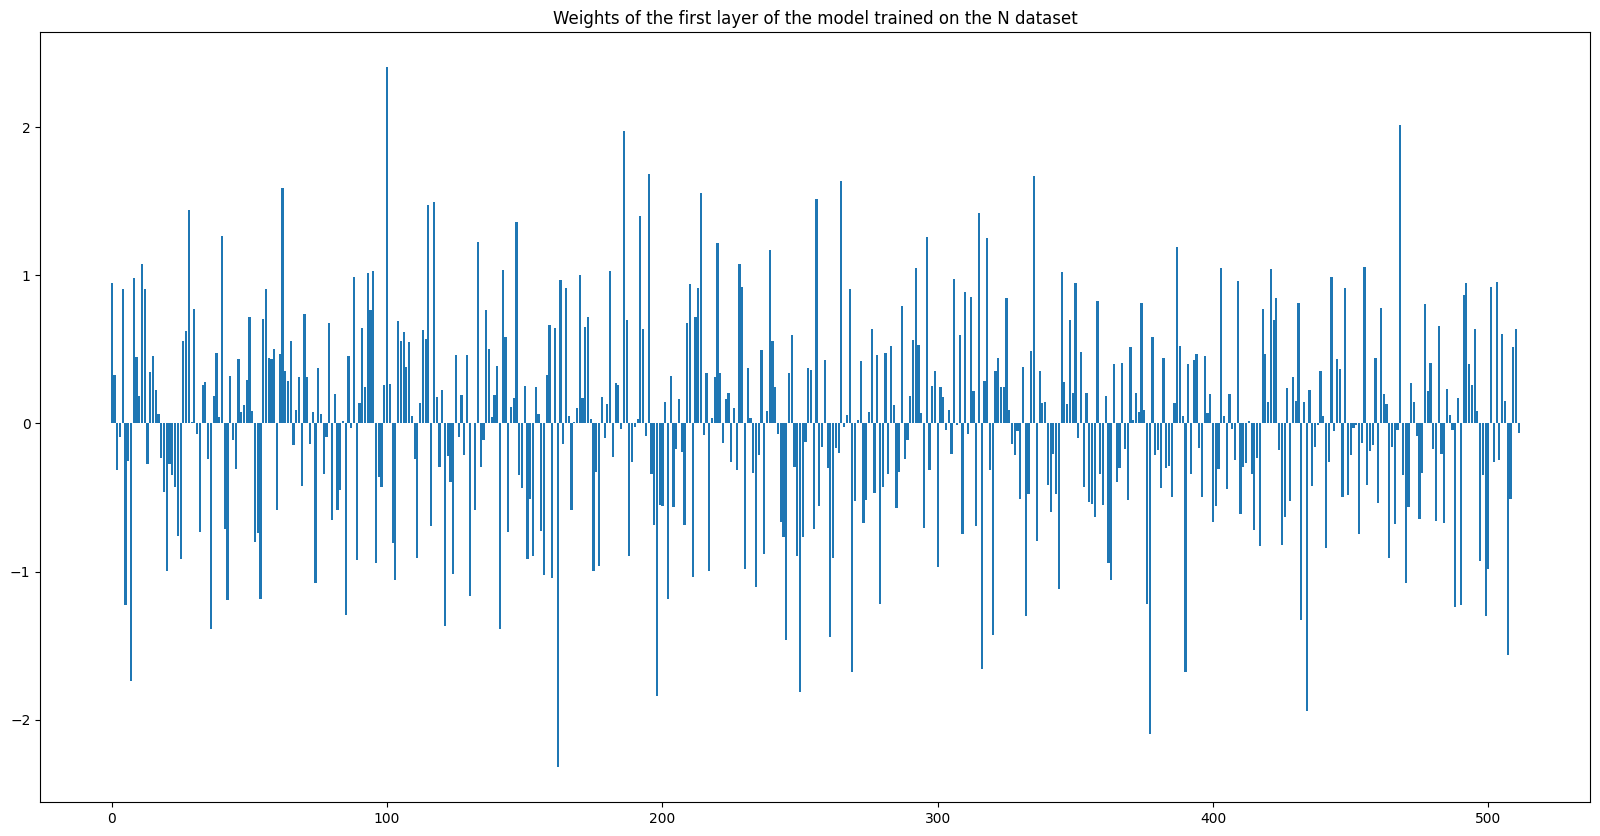

In [86]:
weights_N_0 = weights_df.iloc[0, :]
weights_N_0

# plot weights_N_0
plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_N_0.values)
plt.title('Weights of the first layer of the model trained on the N dataset')
plt.show()

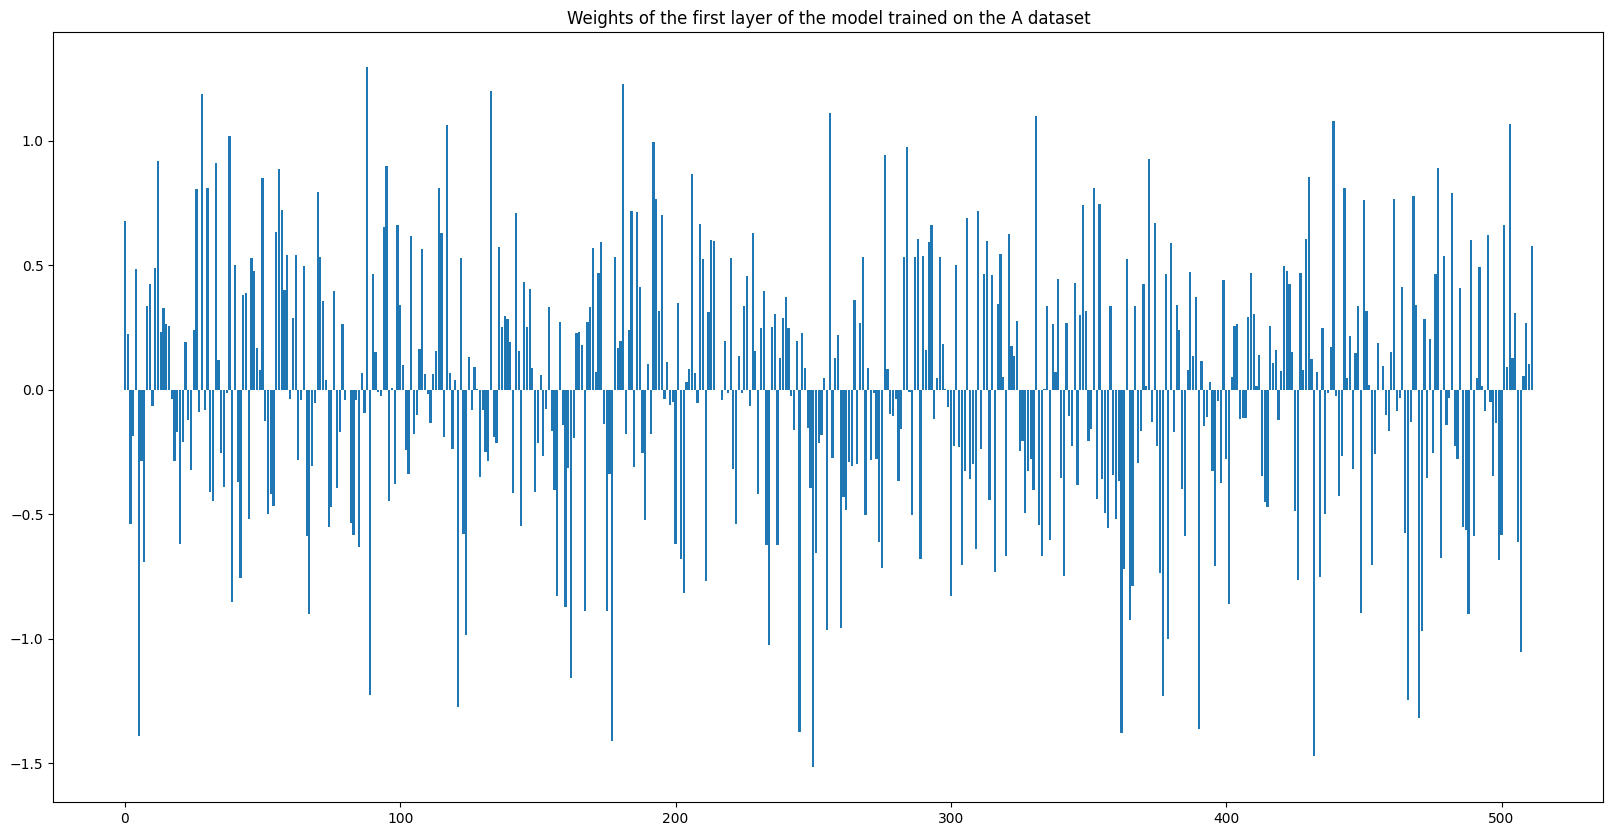

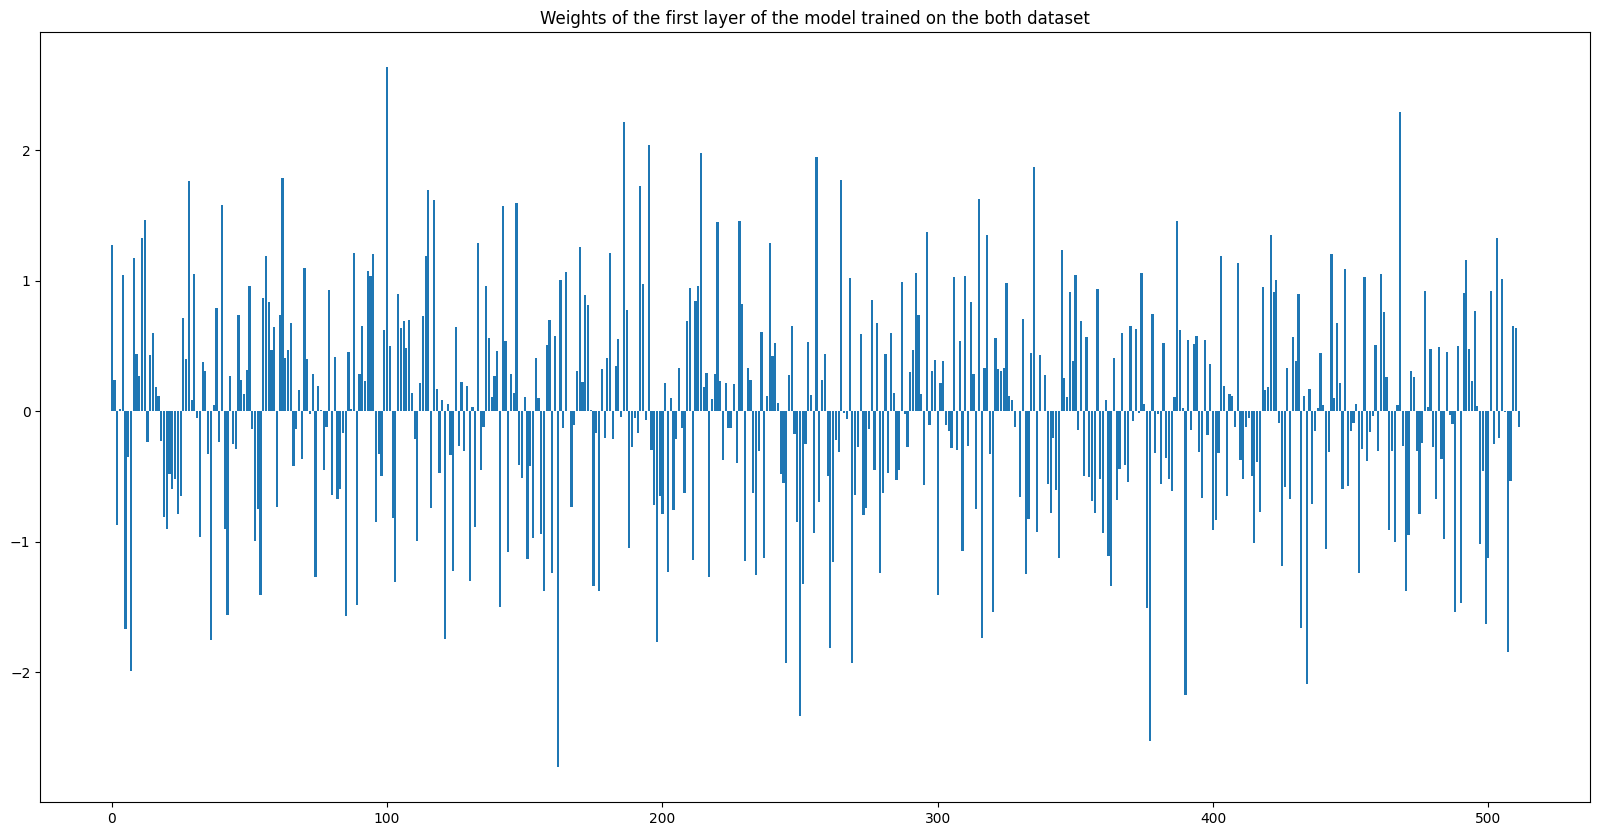

In [89]:
# do the same for the other datasets
weights_A_0 = weights_df.iloc[2, :]
weights_both_0 = weights_df.iloc[4, :]

plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_A_0.values)
plt.title('Weights of the first layer of the model trained on the A dataset')
plt.show()

plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_both_0.values)
plt.title('Weights of the first layer of the model trained on the both dataset')
plt.show()

In [127]:
sorted_features = []
for i in range(3):
    # get the list of weights ordered by decreasing absolute value
    to_sort = weights[i][0]
    to_sort = np.abs(to_sort)
    sorted = np.argsort(to_sort)[::-1]
    sorted_features.append(sorted)

In [128]:
for i in range(3):
    print("Model ", i, " : \n")
    for feat in sorted_features[i][:10]:
        print(f"{int(feat)}: {weights[i][0][int(feat)]}    {weights[i][1][int(feat)]}")

Model  0  : 

100: 2.4049429893493652    -2.423597574234009
162: -2.3213932514190674    2.285126209259033
377: -2.098301649093628    2.1258461475372314
468: 2.0137102603912354    -1.9711201190948486
186: 1.9751569032669067    -1.9794459342956543
434: -1.9402450323104858    1.9071717262268066
198: -1.838673710823059    1.8410512208938599
250: -1.8101658821105957    1.7936745882034302
7: -1.7391866445541382    1.7933846712112427
195: 1.6852684020996094    -1.712106466293335
Model  1  : 

250: -1.5160810947418213    1.5462815761566162
432: -1.4687833786010742    1.4409523010253906
177: -1.4102857112884521    1.3560584783554077
5: -1.3912416696548462    1.4128847122192383
362: -1.3780279159545898    1.3448292016983032
245: -1.3740754127502441    1.35970938205719
390: -1.363929033279419    1.40240478515625
470: -1.3200898170471191    1.255264401435852
88: 1.2956918478012085    -1.241031289100647
121: -1.272502064704895    1.291343092918396
Model  2  : 

162: -2.727080821990967    2.74582886